# week 05
# regression

This week we will focus on regression. We begin by formally setting up regression and outline the assumptions underlying the normal linear models. We then work through examples to talk about:
1. Prior selection.
2. Assessing model performance with posterior predictive checks.
3. Variable selection.
4. Indicator variables.
5. Categorical variables.
6. Variable interactions.
7. Interpreting regression coefficients.

## load libraries

In [1]:
# for reading json files
import json

# numerical libraries
import numpy as np
import scipy as sp
import pystan

# pandas!
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%pylab inline

# pretty graphs
sns.set(style="whitegrid")

Populating the interactive namespace from numpy and matplotlib


# Conditional modeling

Regressions are one of the most widely used statistical techniques. Researchers employ regressions in thousands of articles every year. A regression is a conditional average. We use them to estimate how one variable changes as we vary the value of another. Formally, a regression is a conditional distribution:

$p(y | \theta, x)$

Where:
1. $y$ is a response or outcome variable and is a vector of length $n$.
2. $x$ are explanatory variables, $x = (x_1, \ldots ,x_k)$, and consists of a matrix of size $n \times k$.
3. $\theta$ is a set of parameters.

We observe $n$ observations, units, or subjects of $(x,y)_i$ that allow us to statistically uncover the relationships between the components of $x$ and $y$. At their core regressions compute the expected value of a particular value of $y$ _given_ a set of predictors $x$. Often the expected value is a linear function of the $x$'s:

$E(y_i | \beta, X) = \beta_1 x_{i,1} + \, \ldots \, + \beta_k x_{i,k}$

This modeling choice assumes the conditional expectation of $y$ is a _linear_ function of the columns of $X$. If this is not a reasonable assumption, then you can transform your variables to approximate a linear relationship or abondon the linear setup for one better suited to the problem at hand.

We should note, however, that models built from substantive theory can dramatically outperform linear models of the same phenomena. If you follow the Bayesian Inference Engine, you will have researched theory and what others have done before, so you shouldn't be building a model blindly.


## Ordinary Linear Regression

We restrict our analysis to a special case, ordinary linear regression. This particular regression models the conditional expectation of each data point as outlined above but adds a few additional assumptions that make the model simpler, spurring its wide use among researchers.

### Conditional Independence

Suppose we have $n$ observations of $(x, y)$. If we know the values of $y_j$ and $x_j$, does that inform our estimate of $y_i$ beyond knowing the values of $x_i$ and $\theta$? 

Under the assumption of conditional independence, the answer to this question is no. What this means is once we estimate our regression model, if we need to predict the value of $y_i$ we only need the parameters from the model and $x_i$. Knowing the values of $y_j$ and $x_j$ provide no additional information. 

Let's walk through this more formally. We want to know the joint distribution of $y_i, y_j, x_i, x_j, \theta$. Using the definition of conditional probability, we can decompose this joint distribution as follows:

$p(y_i, y_j, x_i, x_j, \theta) = p(y_i, y_j | x_i, x_j, \theta) p(x_i, x_j)$

Again applying the definition of conditional probability, we can decomponse the first term of the right hand side into another conditional probability:

$p(y_i, y_j | x_i, x_j, \theta) =  p(y_i | y_j, x_i, x_j, \theta) p(y_j | x_i, x_j, \theta)$

Using our assumption of conditional independence, we can simplify both terms on the right hand side by dropping terms that provide no additional information:

$p(y_i, y_j | x_i, x_j, \theta) =  p(y_i | x_i, \theta) p(y_j | x_j, \theta)$

What this says is after we know $x_i$ and $\theta$ there is no additional information about $y_i$ in $y_j$ or $x_j$. It is important to note that $y_j$ and $x_j$ do inform $\theta$, so it is not the case that these values do not contain information about $p(y_i | x_i)$.

What does this assumption get us? It allows us to decompose the joint distribution of $p(\mathbf{y}, \mathbf{x}, \theta)$ into a series of conditional distributions that are easier to estimate:

$p(y_1, \ldots, y_n, x_1, \ldots, x_n, \theta) = p(y_1 | x_1, \theta) \cdots p(y_n | x_n, \theta)$

### Normal densities

Ordinary linear regression assumes that each datapoint is distributed according to a normal distribution, ie that $p(y_i | x_i, \theta)$ is a normal density $\forall i = 1, \ldots, n$. This means that $\mathbf{X}$ and $\theta$ must together define the mean and variance of each normal density. Because we assumed conditional independence, $p(\mathbf{y}, \mathbf{x}, \theta)$ is a multivariate normal distribution with a diagonal covariance matrix, because the covariance between any two different outcome variables, conditional on $\textrm{X}$ and $\theta$, equals zero.

### Linearity of conditional expectation function

Ordinary linear regression assumes the conditional expectation of $y | X, \theta$ is linear:

$E(y_i | \beta, X) = \beta_1 x_{i,1} + \, \ldots \, + \beta_k x_{i,k}$

Thus the mean of the multivariate normal density for datapoint $i$ equals $\beta_1 x_{i,1} + \, \ldots \, + \beta_k x_{i,k}$.

### Conditional homoskedasticity

Ordinary linear regression assumes that the variance of each datapoint conditional on the data is equal. 

$\mathrm{var}(y_i | X) = \sigma^2$ for $i = 1, \ldots, n$.

Thus the covariance matrix is $\mathbf{I}_n \sigma^2$, where $\mathbf{I}_n$ is an identity matrix of dimension $n \times n$.


## Likelihood for ordinary linear regression

Combining all of our assumptions above, we can write down the likelihood for the ordinary linear regression:

$\mathbf{y} | \mathbf{X}, \mathbf{\beta}, \sigma^2 \; \sim \; N(\mathbf{X} \mathbf{\beta}, \sigma^2 \mathbf{I}_n)$


$p(\mathbf{y} | \mathbf{X}, \mathbf{\beta}, \sigma^2) = (2 \pi \sigma^2)^{-n/2} \exp{\left( \frac{(\mathbf{y} - \mathbf{X} \mathbf{\beta})'(\mathbf{y} - \mathbf{X} \mathbf{\beta})}{2 \sigma^2} \right)}$


## Where do regression models fit?
Why would you want to build a regression model with all of these assumptions? Why not just build a flexible machine learning model?

1. Regression models are extremely widespread across many, many disciplines. Understanding how they work will make you a more informed consumer of the insights regressions generate.

2. You can build extremely flexible regression models by combining various distributions or adding multiple levels to exploit hierarchies in your data. Once you invest some time in understanding how regression models work and fail, extensions to simpler models will become easier to see.

3. Regression models can be built out of theory which can dramatically improve model performance. As an example, a soon to be published research article by a team of researchers lead by super star economist, Susan Athey, built [SHOPPER](https://arxiv.org/abs/1711.03560) a Bayesian model of consumer behavior that was shown to outperform state of the art machine learning models:

>SHOPPER is a hierarchical latent variable model of market baskets for which the generative process comes from an assumed model of consumer behavior. In the language of social science, shopper is a structural model of consumer behavior, where the elements of the model include the specification of consumer preferences, information, and behavior (i.e., utility maximization). In the language of probabilistic models, it can equivalently be defined by a generative model.

This is not to say that regression models outperform machine learning models in general...just that one approach is not guaranteed to have better performance. If you have good theory about what you are modeling, building a generative regression model will not be a bad place to start.

Back to ordinary linear regression...

## Bayesian ordinary linear regression

We conduct Bayesian inference to recover the parameters $\beta$ and $\sigma^2$ required by ordinary linear regression. To do this, we apply Bayes' rule:

$p(\mathbf{\theta} | \mathbf{y,X}) \, \propto \, p(\mathbf{y,X}|\mathbf{\theta}) p(\mathbf{\theta})$

## Priors for ordinary linear regression

How should we set the priors in this setting?

For an extensive discussion on prior selection in ordinary linear (and many other) regression models, please consult this section of the Stan website [https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

A few highlights from this page:
> 1. Weakly informative prior should contain enough information to regularize: the idea is that the prior rules out unreasonable parameter values but is not so strong as to rule out values that might make sense.
2. Weakly informative rather than fully informative: the idea is that the loss in precision by making the prior a bit too weak (compared to the true population distribution of parameters or the current expert state of knowledge) is less serious than the gain in robustness by including parts of parameter space that might be relevant. 
3. When using informative priors, be explicit about every choice; write a sentence about each parameter in the model.
4. Don't use uniform priors, or hard constraints more generally, unless the bounds represent true constraints (such as scale parameters being restricted to be positive, or correlations restricted to being between -1 and 1).

Be explicit about your prior choices. **Write down a sentence about each parameter in the model.**

## How to check regression models?

From McElreath _Statistical Rethinking_:
>Plot posterior distributions and posterior predictions rather than try to understand a table of coefficients.

In short, follow all the advice we've already given you. Estimate your model, then conduct posterior predictive checks. Use the posterior of the parameters to conduct the Bayesian two-step, predict distribution of each observation, and construct test statistics. For example, if you are trying to explain differences in income between people under and over 50, predictive accuracy of your model for people over 50 might be more important to you than its predictive accurary for another demographic group.

One model check specific to regression models is analysis of the residuals. What is the residual? It is the different between your model's prediction and the actual value:

$\epsilon_i = y_i - X_i \hat{\beta}$

where $\hat{\beta}$ is the mean of the posterior of the parameter $\beta$. 


In [32]:
# generate some fake data to run through a regression
x = np.random.normal(0,1,size=(100,5))
beta_true = np.random.normal(0,0.5,size=5)
noise = np.random.normal(0,0.5,size=100)
y = x.dot(beta_true) + noise

In [33]:
print(beta_true)

[-0.23695577 -0.44825403 -0.31466226  0.07899026  0.01173449]


#### A somewhat generic ordinary linear model in Stan

Taking the advice from Gelman etal, we provide a stock ordinary linear regression for your use. This is only a starting point. If you use this on actual data, conduct the prior predictive checks we talked about to tweak these priors. These priors are more likely to work if the input data is mean zero and on a common scale. In general it is a good idea to standardize data input into a regression by subtracting each variable by its mean and dividing it by its standard deviation. This means that regression coefficients are interpreted in units of standard deviations with respect to each predictor.

_terminology note_ You will often see the term "ordinary least squares" or OLS. This model is the same as what we have been referring to as the ordinary linear regression.

In [18]:
# a stan model to fit a poisson distribution
f = open('../stan/ols.stan', 'r')
file_contents = f.read()
print (file_contents)
f.close()

// generic ols model
data {
  int<lower=1> N;       // number of observations
  int<lower=1> K;       // number of variables/predictors/features
  matrix[N,K] x;        // matrix of explanatory variables/predictor matrix/features
  vector[N] y;          // outcome vector
}
parameters {
  vector[K] beta;       // regression coefficients
  real<lower=0> sigma;  // standard deviation of normal distr
}
model {
  // priors
  beta ~ student_t(4,0,1);
  sigma ~ student_t(4,0,2);

  // likelihood
  y ~ normal(x * beta, sigma);
}
generated quantities {
  vector[N] y_hat;      // vector of predicted outcomes
  vector[N] loglik;     // vector of log likelihood for checks

  for (i in 1:N) {
      y_hat[i] = normal_rng(x[i] * beta, sigma);
      loglik[i] = normal_lpdf(y[i] | x[i] * beta, sigma);
  }
}



#### What does a student_t prior look like?

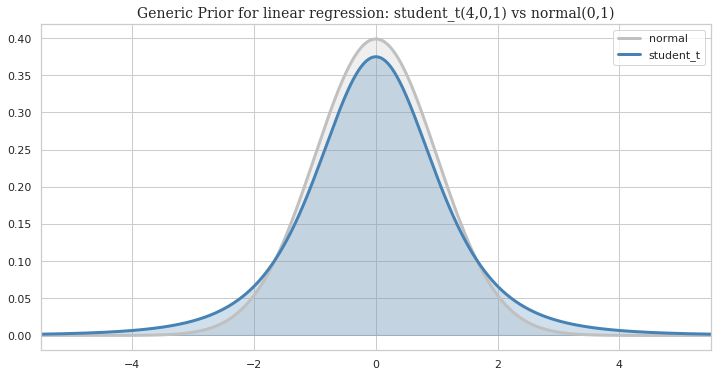

In [142]:
x_d = np.linspace(-7.5,7.5,1000)
y_norm = sp.stats.norm.pdf(x_d,0,1)
y_t = sp.stats.t.pdf(x_d,4,0,1)

plt.figure(figsize=(12,6))

plt.plot(x_d,y_norm,lw=3,color='silver',label='normal')
plt.fill_between(x_d,np.zeros(len(x_d)),y_norm,color='silver',alpha=0.25)

plt.plot(x_d,y_t,lw=3,color='steelblue',label='student_t')
plt.fill_between(x_d,np.zeros(len(x_d)),y_t,color='steelblue',alpha=0.25)

plt.xlim(-5.5,5.5)
plt.legend()
plt.title('Generic Prior for linear regression: student_t(4,0,1) vs normal(0,1)',fontfamily='serif',fontsize=14);

#### Let's fit our generic model to our simulated data

In [19]:
ols = pystan.StanModel(file='../stan/ols.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_540057f378e4e20684214018dba04e92 NOW.


In [34]:
# feed stan some data
data_dict = {'N':len(x),'K':x.shape[1],'x':x,'y':y}

In [35]:
# conduct MCMC using Stan
ols_draws = ols.sampling(data=data_dict, iter=1000, chains=4)

In [36]:
# give us a dictionary containing posterior draws for each parameter in the model
ols_pstr = ols_draws.extract(permuted=True)

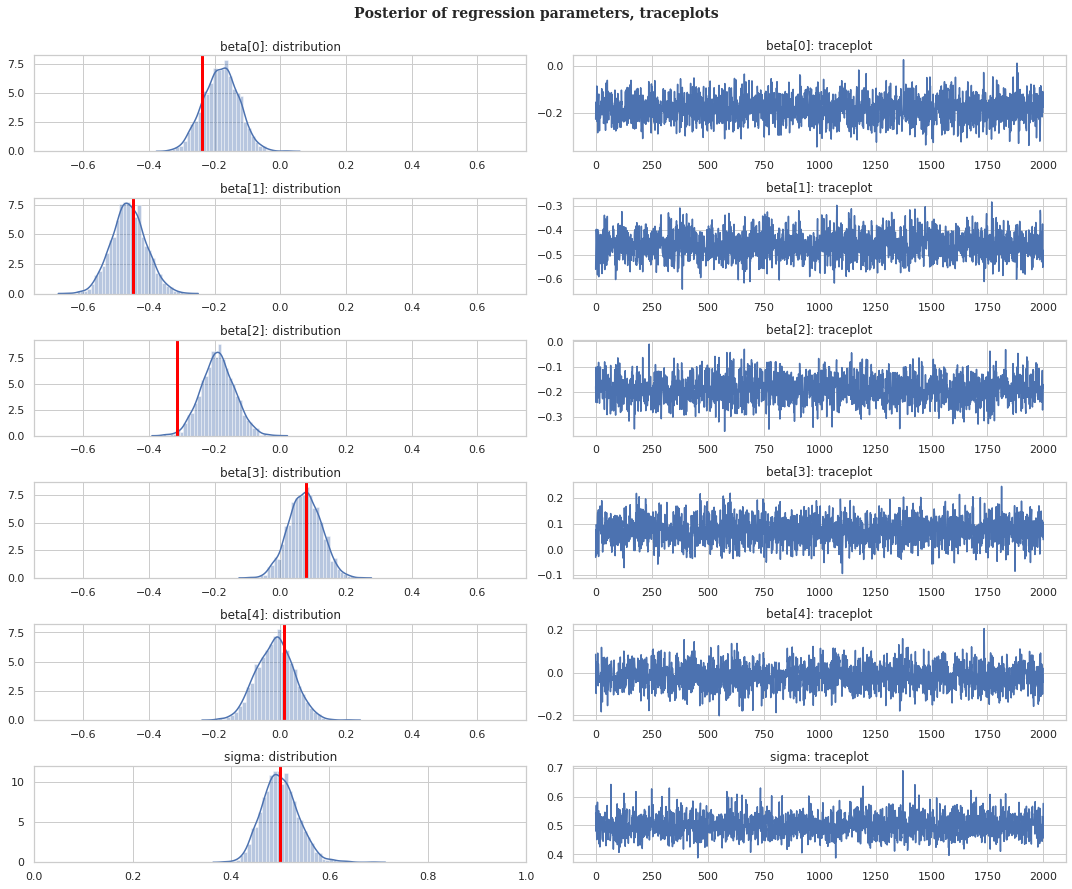

In [64]:
# Initialise the figure and a subplot axes.
num_rows = data_dict['K'] + 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 12),sharex=False,sharey=False)

# overall title
fig.suptitle('Posterior of regression parameters, traceplots',
             y=1.025,fontsize=14,fontfamily='serif',fontweight='bold')

# plot beta's
for i in range(data_dict['K']):
    sns.distplot(ols_pstr['beta'][:,i],ax=ax[i,0])
    ax[i,0].axvline(beta_true[i],lw=3,color='red')
    ax[i,0].set_title('beta['+str(i)+']: distribution')
    ax[i,0].set_xlim(-0.75,0.75)
    ax[i,1].plot(ols_pstr['beta'][:,i])
    ax[i,1].set_title('beta['+str(i)+']: traceplot')

# plot variance
sns.distplot(ols_pstr['sigma'],ax=ax[data_dict['K'],0])
ax[data_dict['K'],0].axvline(0.5,lw=3,color='red')
ax[data_dict['K'],0].set_title('sigma: distribution')
ax[data_dict['K'],0].set_xlim(0,1)
ax[data_dict['K'],1].plot(ols_pstr['sigma'])
ax[data_dict['K'],1].set_title('sigma: traceplot')
    
# make the plot prettier
plt.tight_layout()
plt.show();

#### Plot Predicted Values against Actuals

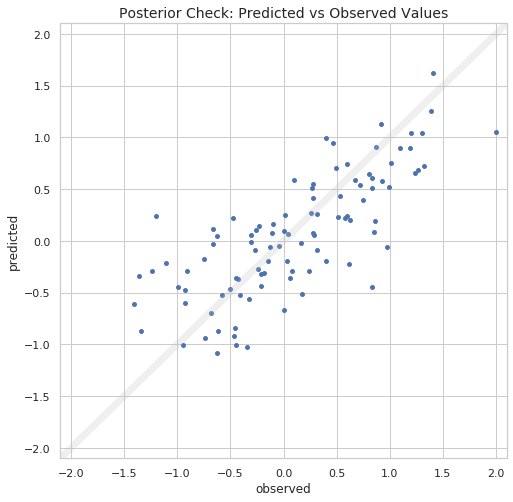

In [78]:
plt.figure(figsize=(8,8))
plt.plot(np.linspace(-2.1,2.1,100),np.linspace(-2.1,2.1,100),lw=7,alpha=0.25,color='silver')
plt.scatter(y,mean_y_hat,s=15)
plt.title('Posterior Check: Predicted vs Observed Values',fontsize=14)
plt.xlim(-2.1,2.1)
plt.ylim(-2.1,2.1)
plt.xlabel('observed')
plt.ylabel('predicted');

#### Residual plots

In [55]:
# compute residuals across ALL posterior draws
resid = ols_pstr['y_hat'] - y

# compute the mean of the residuals 
mean_resid = np.mean(resid,axis=0)

# and the mean of the predictions
mean_y_hat = np.mean(ols_pstr['y_hat'],axis=0)

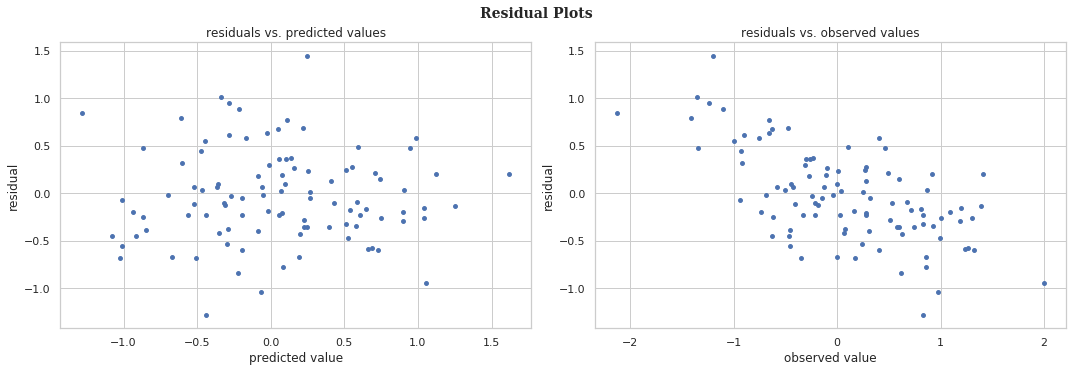

In [81]:
# Initialise the figure and a subplot axes.
num_rows = 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 5),sharex=False,sharey=False)

# overall title
fig.suptitle('Residual Plots',
             y=1.025,fontsize=14,fontfamily='serif',fontweight='bold')

ax[0].scatter(mean_y_hat,mean_resid,s=15)
ax[0].set_title('residuals vs. predicted values')
ax[0].set_xlabel('predicted value')
ax[0].set_ylabel('residual')
ax[1].scatter(y,mean_resid,s=15)
ax[1].set_title('residuals vs. observed values')
ax[1].set_xlabel('observed value')
ax[1].set_ylabel('residual')

# make the plot prettier
plt.tight_layout()
plt.show();

#### The left plot
The left plot shows that the residuals have no apparent relationship with the predictions. In other words the model's errors are not related to the level of the predicted value. If we saw a clear pattern in this plot, we have more work to do!

#### The right plot
What's this all about? Why a relationship between the residual and the outcome variable? The errors in a regression should be independent of the predictors, not the outcome data. Even if we simulated data and recovered the parameters well, we get a relationship between the model errors and the outcome variable.

#### What should you do in the future?
Plot residuals versus predicted values!

#### Many regression lines
With Bayesian regression, you get _many_ regression models. Let's create an example with just one regressor.

In [102]:
# generate some fake data to run through a regression
x = np.random.normal(0,1,size=(100,1))
beta_true = np.random.normal(0,0.5,size=1)
noise = np.random.normal(0,0.5,size=100)
y = x.dot(beta_true) + noise

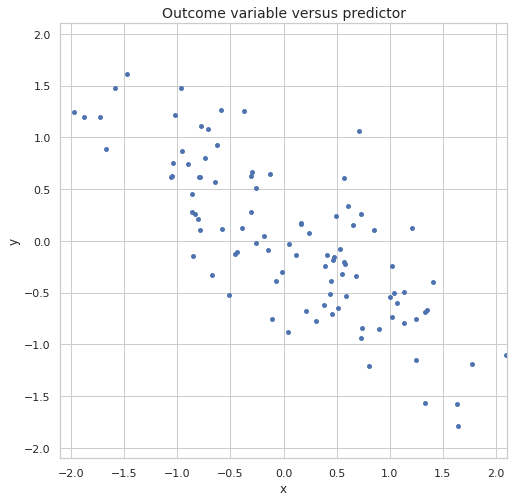

In [107]:
plt.figure(figsize=(8,8))
plt.scatter(x[:,0],y,s=15)
plt.title('Outcome variable versus predictor',fontsize=14)
plt.xlim(-2.1,2.1)
plt.ylim(-2.1,2.1)
plt.xlabel('x')
plt.ylabel('y');

In [103]:
# feed stan some data
data_dict = {'N':len(x),'K':x.shape[1],'x':x,'y':y}

In [104]:
# conduct MCMC using Stan
ols_draws = ols.sampling(data=data_dict, iter=1000, chains=4)

In [105]:
# give us a dictionary containing posterior draws for each parameter in the model
ols_pstr = ols_draws.extract(permuted=True)

#### Let's plot

We have 2,000 regression lines from MCMC. Let's plot a few against the data for $y$ and $x_1$.

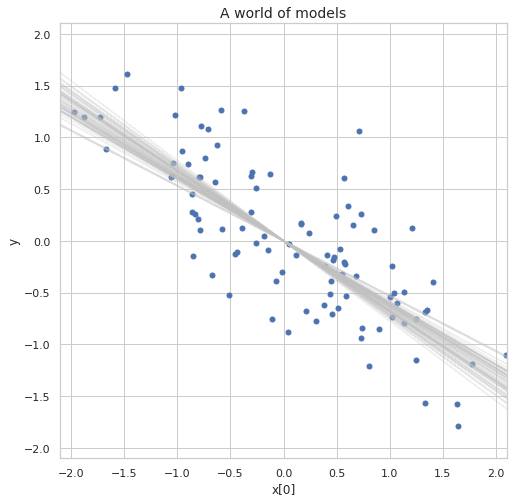

In [114]:
idx = np.random.choice(np.arange(len(ols_pstr['beta'])),size=50,replace=False)

plt.figure(figsize=(8,8))

for i in range(len(idx)):
    plt.plot(x[:,0],x[:,0] * ols_pstr['beta'][idx[i],0],'-',color='silver',lw=1,alpha=0.25)

plt.scatter(x[:,0],y,s=25)
    
plt.title('A world of models',fontsize=14)
plt.xlim(-2.1,2.1)
plt.ylim(-2.1,2.1)
plt.xlabel('x[0]')
plt.ylabel('y');



## Variable selection
Variable selection is one of the most difficult parts of regression analysis. Gelman and Hill have this advice:

>Most importantly, the data you are analyzing should map to the research question you are trying to answer. The outcome measure should accurately reflect the phenomenon of interest, the model should include all relevant predictors, and the model should generalize to the cases to which it will be applied.

It can be very difficult to know what "all relevant predictors" are for your problem. General advice is to have a theory about what you are trying to answer and knowledge of what others who have gone before have done. There are a couple of specific pieces of advice.

### Look at correlations among predictors

You should look at relationships among your predictors. If there is a high degree of correlation between two predictors, this can cause problems for your estimation and, in some cases, make it fail. If you have two highly linearly related predictors and they both measure shades of the same concept, you can drop one of them, run the model, then drop the other and run the model. This strategy does not scale to cases with lots of variables, so in that case...

### Sometimes you need a fancy prior
When you have a large number of predictors and want to enforce sparsity, there are many ways to do that. One way is to make a prior that helps the estimation push small coefficients to zero. These fancy priors all have fun names: spike and slab is one; horeshoe is another.

### When additivity and linearity are not enough
A _linear_ regression assumes that the deterministic part of the model is a linear function of the predictors. If additivity is violated, you can transform your data (e.g. using logs) or add interactions (more on that later). If linearity is violated, you can add nonlinear transformations of your input variables, for example "age" and "age sqaured". 

## Indicator variables

Indicator variables take on a value of "1" when a condition is met and "0" otherwise. Gender is a frequent indicator variable that can equal 1 for observation $i$ if the person is a female. 

## Categorial variables

Categorical variables take on a fixed number of values that represent categories of a predictor variable. Income quartile is an example of a categorical variable that would equal "1" if income of a person was in the lowest quartile and "4" if income was in the highest quartile.

You can convert a categorical variable into a series of indicator variables. For example, you could convert the income quartile variable into 4 indicator variables, where the first variable equals "1" is the person is in the bottom quartile. Why would you want to do this? 

A categorical variable forces the model to find a linear relationship between different levels of the categorical variable and the outcome variable. Suppose you have a hypothesis that changes in the outcome variable change nonlinearlly with different categories. In this case you could construct 4 indicator variables out of the income quartile categorical variable. 

However, you cannot put all of these indicator variables into the same regression. These variables would be perfectly collinear, ie if you knew the value of any three of the variables, you always know the value of the fourth. 

## Interactions between variables

Modeling interactions between variables is another way to increase the capacity of a regression model to learn more about the conditional distribution (neural networks learn complex patterns by supercharging the idea of variable interactions). For example, suppose we think education has a different effect on females. To test this hypothesis we can create a new variable called "female-education" and add this to the regression. This allows the model to learn whether the combination of these two variables has an additional effect beyond the effects of education and being female already have. 

You can generalize the idea of interactions to many variables, but you will eventually hit against data constraints and at some point before that, your ability to interpret those coefficients will erode. To ease interpretability with interaction terms, use draws from the posterior predictions to compute the distribution of cases with and without a variable of interest. For example, if there are complex interactions between gender and other variables in your model, divide your data by gender and plot the distribution of outcomes for each.

## Working through an example

We're going to work through an example from McElreath's _Statistical Rethinking_ to provide concrete examples of Bayesian regression analysis.

### A Puzzle
>Africa is special. The second largest continent, it is the most culturally and genetically diverse. Africa has about 3 billion fewer people than Asia, but it has just as many living languages. Africa is also geographically special, in a puzzling way: Bad geography tends to be related to bad economies outside of Africa, but African economies seem immune to bad geography.



#### Load data

In [207]:
# load data
a_data = pd.read_csv('../data/africa_rugged.csv',sep=';')

# drop na's on GDP
a_data.dropna(subset=['rgdppc_2000'],inplace=True)

# create logs of GDP
a_data['log_rgdpppc_2000'] = np.log(a_data.rgdppc_2000)
a_data.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_rgdpppc_2000
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.000,7.492609
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.000,8.216929
7,ARE,784,United Arab Emirates,0.769,0.316,2.112,0.191,6.142,8360.0,23.913,...,0,0,0.0,NaN,NaN,NaN,NaN,19200.0,0.000,9.933263
8,ARG,32,Argentina,0.775,0.220,2.268,0.226,9.407,273669.0,-35.396,...,0,0,0.0,NaN,NaN,NaN,NaN,276632.0,89.889,9.407032
9,ARM,51,Armenia,2.688,0.934,8.178,0.799,50.556,2820.0,40.294,...,0,0,0.0,NaN,NaN,NaN,NaN,105743.0,0.500,7.792343


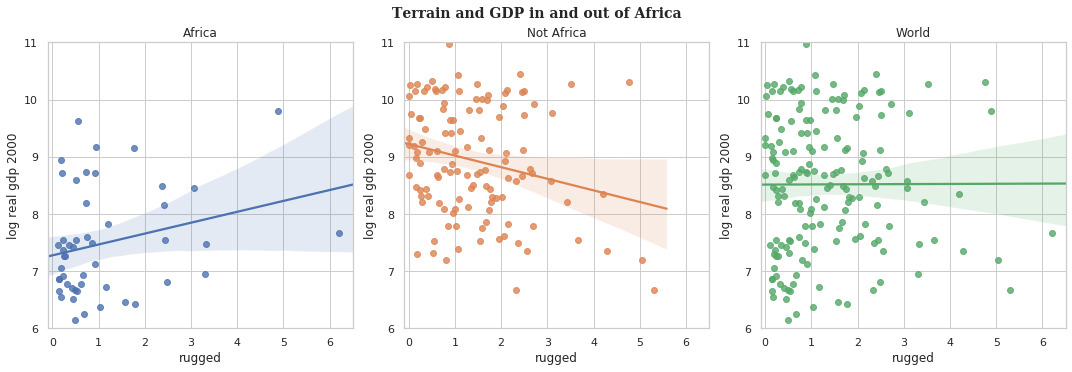

In [208]:
# Initialise the figure and a subplot axes.
num_rows = 1
num_cols = 3
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 5),sharex=False,sharey=False)

# overall title
fig.suptitle('Terrain and GDP in and out of Africa',
             y=1.025,fontsize=14,fontfamily='serif',fontweight='bold')


sns.regplot(x='rugged',y='log_rgdpppc_2000',data=a_data[a_data.cont_africa == 1],ax=ax[0])
ax[0].set_xlim(-0.1,6.5)
ax[0].set_ylim(6,11)
ax[0].set_title('Africa')
ax[0].set_xlabel('rugged')
ax[0].set_ylabel('log real gdp 2000')

sns.regplot(x='rugged',y='log_rgdpppc_2000',data=a_data[a_data.cont_africa == 0],ax=ax[1])
ax[1].set_xlim(-0.1,6.5)
ax[1].set_ylim(6,11)
ax[1].set_title('Not Africa')
ax[1].set_xlabel('rugged')
ax[1].set_ylabel('log real gdp 2000')

sns.regplot(x='rugged',y='log_rgdpppc_2000',data=a_data,ax=ax[2])
ax[2].set_xlim(-0.1,6.5)
ax[2].set_ylim(6,11)
ax[2].set_title('World')
ax[2].set_xlabel('rugged')
ax[2].set_ylabel('log real gdp 2000')
# make the plot prettier
plt.tight_layout()
plt.show();

#### How can we get our regression to model different slopes simultaneously?

First, let's see what happens when we estimate an ordinary linear regression with a constant and one variable, rugged.

In [209]:
# first step is to add a constant to our matrix of predictors
x_africa = np.vstack([np.ones(len(a_data)),a_data.rugged]).T
x_africa[:5]

array([[1.   , 0.858],
       [1.   , 3.427],
       [1.   , 0.769],
       [1.   , 0.775],
       [1.   , 2.688]])

In [210]:
# feed stan some data
africa_dict = {'N':len(x_africa),'K':x_africa.shape[1],'x':x_africa,'y':a_data.log_rgdpppc_2000}

In [211]:
# conduct MCMC using Stan
africa_m1_draws = ols.sampling(data=africa_dict, iter=1000, chains=4)

In [216]:
#print(africa_m1_draws)

In [212]:
# give us a dictionary containing posterior draws for each parameter in the model
africa_m1_pstr = africa_m1_draws.extract(permuted=True)

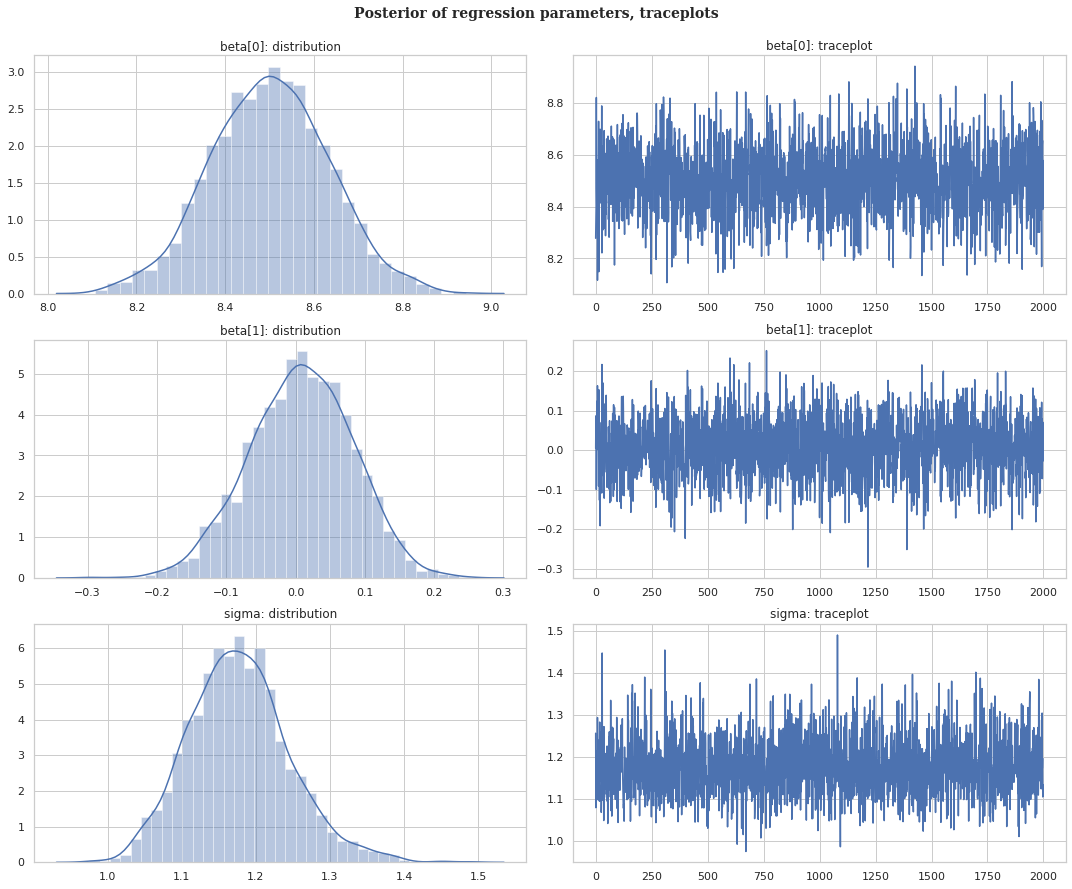

In [214]:
# Initialise the figure and a subplot axes.
num_rows = africa_dict['K'] + 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 12),sharex=False,sharey=False)

# overall title
fig.suptitle('Posterior of regression parameters, traceplots',
             y=1.025,fontsize=14,fontfamily='serif',fontweight='bold')

# plot beta's
for i in range(africa_dict['K']):
    sns.distplot(africa_m1_pstr['beta'][:,i],ax=ax[i,0])
    ax[i,0].set_title('beta['+str(i)+']: distribution')
    #ax[i,0].set_xlim(-0.75,0.75)
    ax[i,1].plot(africa_m1_pstr['beta'][:,i])
    ax[i,1].set_title('beta['+str(i)+']: traceplot')

# plot variance
sns.distplot(africa_m1_pstr['sigma'],ax=ax[africa_dict['K'],0])
ax[africa_dict['K'],0].set_title('sigma: distribution')
#ax[africa_dict['K'],0].set_xlim(0,1)
ax[africa_dict['K'],1].plot(africa_m1_pstr['sigma'])
ax[africa_dict['K'],1].set_title('sigma: traceplot')
    
# make the plot prettier
plt.tight_layout()
plt.show();

#### Predicted lines versus actual

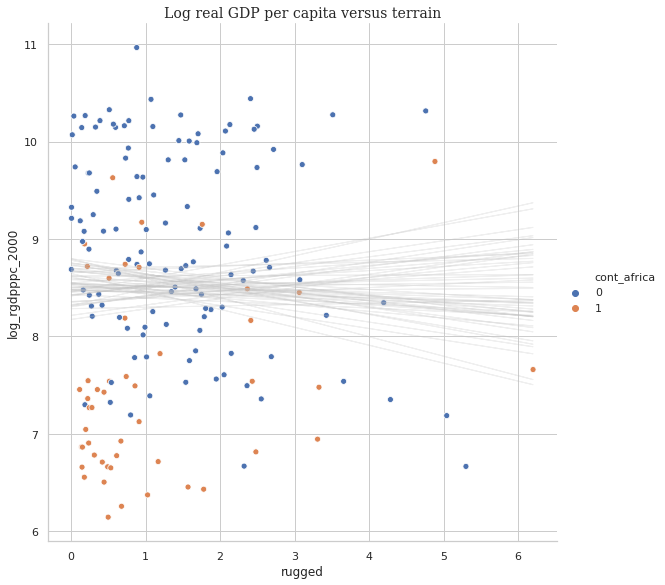

In [226]:
idx = np.random.choice(np.arange(len(africa_m1_pstr['beta'])),size=50,replace=False)
sns.relplot(x='rugged',y='log_rgdpppc_2000',data=a_data,hue='cont_africa',height=8)

for i in range(len(idx)):
    plt.plot(x_africa[:,1],africa_m1_pstr['beta'][idx[i],0] + x_africa[:,1] * africa_m1_pstr['beta'][idx[i],1],'-',color='silver',lw=1,alpha=0.25)
    
plt.title('Log real GDP per capita versus terrain',fontfamily='serif',fontsize=14);

#### That didn't work
A model with just a constant and terrain did not capture the differences in slopes across countries.

#### Let's try adding an indicator
Let's add another variable which is an indicator, "1" if country is in Africa, "0" otherwise.

In [227]:
# first step is to add a constant to our matrix of predictors
x_africa = np.vstack([np.ones(len(a_data)),a_data.rugged,a_data.cont_africa]).T
x_africa[:5]

array([[1.   , 0.858, 1.   ],
       [1.   , 3.427, 0.   ],
       [1.   , 0.769, 0.   ],
       [1.   , 0.775, 0.   ],
       [1.   , 2.688, 0.   ]])

In [228]:
# feed stan some data
africa_dict = {'N':len(x_africa),'K':x_africa.shape[1],'x':x_africa,'y':a_data.log_rgdpppc_2000}

In [229]:
# conduct MCMC using Stan
africa_m2_draws = ols.sampling(data=africa_dict, iter=1000, chains=4)

In [230]:
# give us a dictionary containing posterior draws for each parameter in the model
africa_m2_pstr = africa_m2_draws.extract(permuted=True)

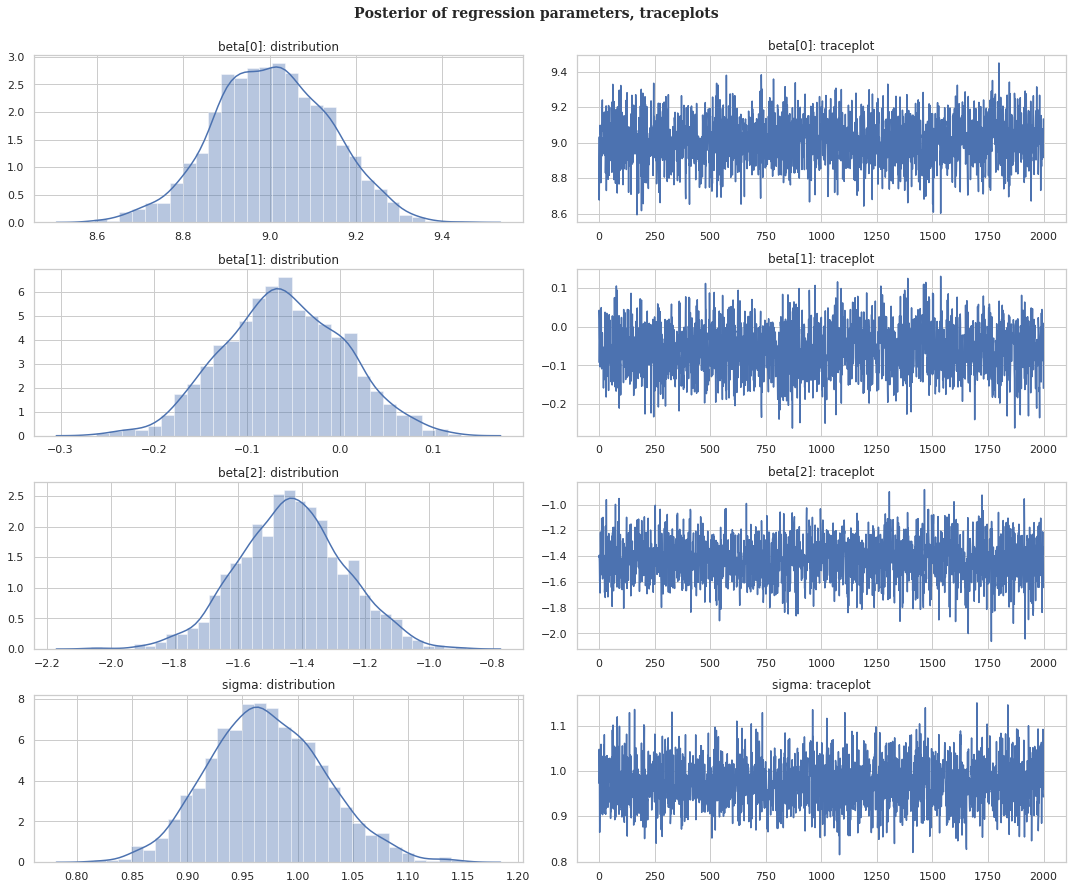

In [231]:
# Initialise the figure and a subplot axes.
num_rows = africa_dict['K'] + 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 12),sharex=False,sharey=False)

# overall title
fig.suptitle('Posterior of regression parameters, traceplots',
             y=1.025,fontsize=14,fontfamily='serif',fontweight='bold')

# plot beta's
for i in range(africa_dict['K']):
    sns.distplot(africa_m2_pstr['beta'][:,i],ax=ax[i,0])
    ax[i,0].set_title('beta['+str(i)+']: distribution')
    #ax[i,0].set_xlim(-0.75,0.75)
    ax[i,1].plot(africa_m2_pstr['beta'][:,i])
    ax[i,1].set_title('beta['+str(i)+']: traceplot')

# plot variance
sns.distplot(africa_m2_pstr['sigma'],ax=ax[africa_dict['K'],0])
ax[africa_dict['K'],0].set_title('sigma: distribution')
#ax[africa_dict['K'],0].set_xlim(0,1)
ax[africa_dict['K'],1].plot(africa_m2_pstr['sigma'])
ax[africa_dict['K'],1].set_title('sigma: traceplot')
    
# make the plot prettier
plt.tight_layout()
plt.show();

#### Predicted lines versus actual

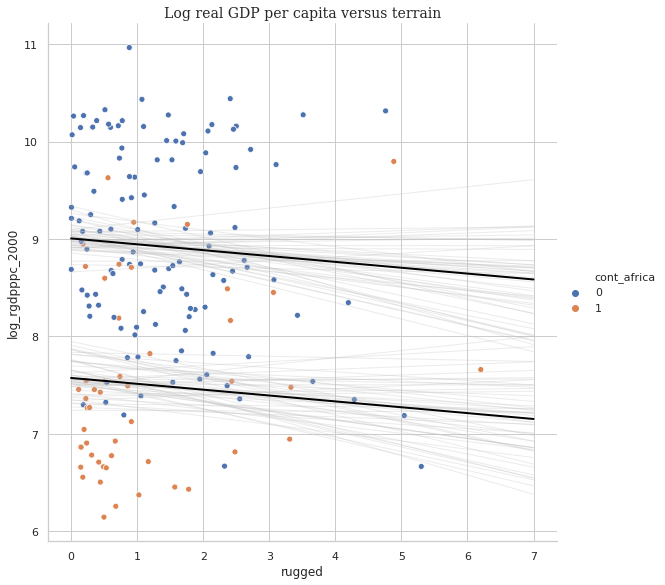

In [250]:
idx = np.random.choice(np.arange(len(africa_m2_pstr['beta'])),size=50,replace=False)
sns.relplot(x='rugged',y='log_rgdpppc_2000',data=a_data,hue='cont_africa',height=8)

for i in range(len(idx)):
    plt.plot(x_plot,africa_m2_pstr['beta'][idx[i],0] + x_plot * africa_m2_pstr['beta'][idx[i],1] + 1 * africa_m2_pstr['beta'][idx[i],2],'-',color='silver',alpha=0.3,lw=1)
    plt.plot(x_plot,africa_m2_pstr['beta'][idx[i],0] + x_plot * africa_m2_pstr['beta'][idx[i],1] + 0 * africa_m2_pstr['beta'][idx[i],2],'-',color='silver',alpha=0.3,lw=1)

plt.plot(x_plot,np.mean(africa_m2_pstr['beta'][:,0]) + x_plot * np.mean(africa_m2_pstr['beta'][:,1]) + 1 * np.mean(africa_m2_pstr['beta'][:,2]),'-',color='black',lw=2)
plt.plot(x_plot,np.mean(africa_m2_pstr['beta'][:,0]) + x_plot * np.mean(africa_m2_pstr['beta'][:,1]) + 0 * np.mean(africa_m2_pstr['beta'][:,2]),'-',color='black',lw=2)

    
plt.title('Log real GDP per capita versus terrain',fontfamily='serif',fontsize=14);

#### What did this do?
Adding an indicator variable for Africa got us two lines with different _intercepts_ but identical slopes.

#### Let's add an interaction
Let's multiply the indicator for Africa and the terrain variable, add that to the model, and re-estimate.

In [251]:
# first step is to add a constant to our matrix of predictors
x_africa = np.vstack([np.ones(len(a_data)),a_data.rugged,a_data.cont_africa,a_data.cont_africa * a_data.rugged]).T
x_africa[:5]

array([[1.   , 0.858, 1.   , 0.858],
       [1.   , 3.427, 0.   , 0.   ],
       [1.   , 0.769, 0.   , 0.   ],
       [1.   , 0.775, 0.   , 0.   ],
       [1.   , 2.688, 0.   , 0.   ]])

In [252]:
# feed stan some data
africa_dict = {'N':len(x_africa),'K':x_africa.shape[1],'x':x_africa,'y':a_data.log_rgdpppc_2000}

In [253]:
# conduct MCMC using Stan
africa_m3_draws = ols.sampling(data=africa_dict, iter=1000, chains=4)

In [254]:
# give us a dictionary containing posterior draws for each parameter in the model
africa_m3_pstr = africa_m3_draws.extract(permuted=True)

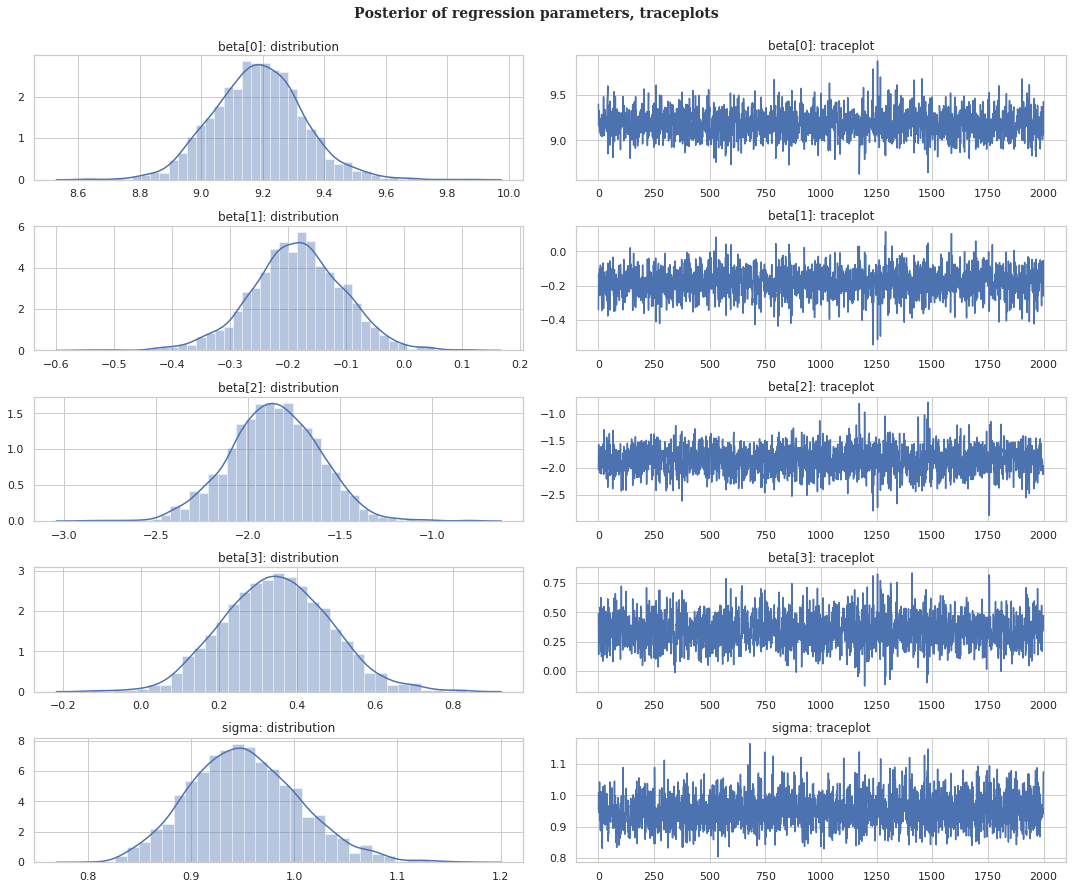

In [255]:
# Initialise the figure and a subplot axes.
num_rows = africa_dict['K'] + 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 12),sharex=False,sharey=False)

# overall title
fig.suptitle('Posterior of regression parameters, traceplots',
             y=1.025,fontsize=14,fontfamily='serif',fontweight='bold')

# plot beta's
for i in range(africa_dict['K']):
    sns.distplot(africa_m3_pstr['beta'][:,i],ax=ax[i,0])
    ax[i,0].set_title('beta['+str(i)+']: distribution')
    #ax[i,0].set_xlim(-0.75,0.75)
    ax[i,1].plot(africa_m3_pstr['beta'][:,i])
    ax[i,1].set_title('beta['+str(i)+']: traceplot')

# plot variance
sns.distplot(africa_m3_pstr['sigma'],ax=ax[africa_dict['K'],0])
ax[africa_dict['K'],0].set_title('sigma: distribution')
#ax[africa_dict['K'],0].set_xlim(0,1)
ax[africa_dict['K'],1].plot(africa_m3_pstr['sigma'])
ax[africa_dict['K'],1].set_title('sigma: traceplot')
    
# make the plot prettier
plt.tight_layout()
plt.show();

#### Predicted lines versus actual

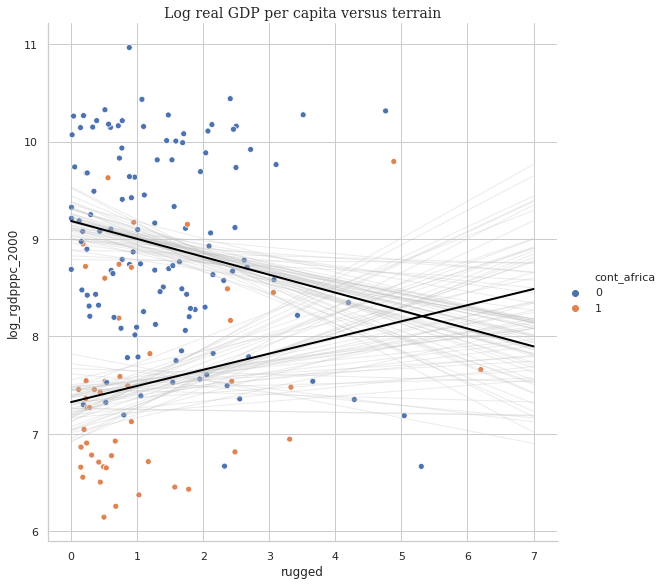

In [257]:
idx = np.random.choice(np.arange(len(africa_m3_pstr['beta'])),size=50,replace=False)
sns.relplot(x='rugged',y='log_rgdpppc_2000',data=a_data,hue='cont_africa',height=8)

for i in range(len(idx)):
    plt.plot(x_plot,africa_m3_pstr['beta'][idx[i],0] + x_plot * africa_m3_pstr['beta'][idx[i],1] + 1 * africa_m3_pstr['beta'][idx[i],2] + 1 * x_plot * africa_m3_pstr['beta'][idx[i],3],'-',color='silver',alpha=0.3,lw=1)
    plt.plot(x_plot,africa_m3_pstr['beta'][idx[i],0] + x_plot * africa_m3_pstr['beta'][idx[i],1] + 0 * africa_m3_pstr['beta'][idx[i],2],'-',color='silver',alpha=0.3,lw=1)

plt.plot(x_plot,np.mean(africa_m3_pstr['beta'][:,0]) + x_plot * np.mean(africa_m3_pstr['beta'][:,1]) + 1 * np.mean(africa_m3_pstr['beta'][:,2]) + 1 * x_plot * np.mean(africa_m3_pstr['beta'][:,3]) ,'-',color='black',lw=2)
plt.plot(x_plot,np.mean(africa_m3_pstr['beta'][:,0]) + x_plot * np.mean(africa_m3_pstr['beta'][:,1]) + 0 * np.mean(africa_m3_pstr['beta'][:,2]),'-',color='black',lw=2)

    
plt.title('Log real GDP per capita versus terrain',fontfamily='serif',fontsize=14);

### Formal measures of fit...

In [334]:
def waic(loglik):
    """
    given log likelihood, 
    computes the widely applicable information criterion
    """
    res_dict = {}
    
    res_dict['lpd'] = np.sum(np.log(np.mean(np.exp(loglik),axis=0)))
    res_dict['p_waic'] = np.sum(np.var(loglik,axis=0))
    res_dict['waic'] = -2 * (res_dict['lpd'] - res_dict['p_waic'])
    
    return res_dict

In [335]:
waic_dict = {}

waic_dict['africa_m1'] = waic(africa_m1_pstr['loglik'])
waic_dict['africa_m2'] = waic(africa_m2_pstr['loglik'])
waic_dict['africa_m3'] = waic(africa_m3_pstr['loglik'])
    

In [336]:
pd.DataFrame(waic_dict).T

,lpd,p_waic,waic
africa_m1,-267.169777,2.614685,539.568924
africa_m2,-233.865487,4.249366,476.229704
africa_m3,-229.643105,5.135316,469.556842


# Bayesian Inference Engine
You can answer almost any question using the Bayesian inference engine that we outline below. While this is a general way of conducting research, it is specifically Bayesian when it comes to taking a theory to the data.

If you follow these steps, you will produce a set of empirically tested insights from a transparent and repeatable model that you and others can build upon. Furthermore, these steps minimize the chance that your model produces a result for the wrong reason or fails to capture key features in your data. 

Talking to colleagues and seeking out diverse perspectives is central to your Bayesian inference efforts, and each step below presents an opportunity to consult with others. We set off coding best practices with _italics_.

## Develop the question
Questions from the world do not arise in a form that is easily answered by a statistical model. Often the necessary data does not exist. Either the action of interest is indirectly observed or data exists in an aggregated form. So there is some amount of work at the beginning in developing the right question to pose to a statistical model. Ponder and scrutinize various forms of the question and iterate until you arrive at one that achieves the right balance of feasibility and usefulness.

## Research methods and subject
Search far and wide for methodological and topical research related to your question. This is a great opportunity to consult people outside of your discpline. Interview subject matter experts. Read some history. Immerse yourself in the topic. What's been done before? 

## Develop Theory
Develop a theory to inform your data choices and to ensure that you're building a model to the questions you have vice the data you have on hand.

## Gather data
Gather as much data as you can and store it in a machine readable format that includes all of the information about what the data is, where you got it, and what each column means. Store raw data, scripts to transform it, and transformed/clean data. _You should have one repeatable script that takes your raw data files as inputs and outputs cleaned data suitable for modeling. Assign unique identifiers to your raw data, transform scripts, and cleaned data._

## Build a model
For a Bayesian, a model is a prior distribution and likelihood. Choosing both necessarily involves a compromise among "scientific knowledge, mathematical convenience, and computational tractability". You should have some ideas for where to start from your research, but you will almost always find yourself in new territory. Take an interative approach. Start small, find the error modes of each model, and use those deficiencies to guide your next step. _Document each model file and treat it as software. Check it into a code repository, assign a unique identifier to each model version, and label all results generated by a model with that identifier._ 

## Perform prior predictive checks
Prior predictive checking serves two purposes: ensuring your priors rule out outrageous values yet maintain the ability to generate many possibilities, and to surface coding errors. This stage involves the Bayesian two-step of generating values from the prior then simulating datasets from the model. Once you have these data samples you can check your code by conducting inference and determining how good the model fits the data, and you can construct a flip-book of prior-generated datasets to assess whether your priors are informed but flexible enough. Is the model capable of generating data resembling your observed data? Are your priors unduly constraining your model, ie is it capable of detecting potentially competing possibilities? _For each model identifier, store a script that recreates the series of prior predictive checks that informed your decisions about the prior and likelihood._

## Recover the posterior
Carry out Bayesian inference by updating your prior knowledge with observed data. Perform a battery of checks on your estimation technique to ensure that you, in fact, are able to generate samples from a posterior. Experience gained during prior predictive checking will inform how your estimation technique might fail with real data. _Store posterior draws in a machine readable format that includes the model and data identifiers as well as the commands you used to estimate the model. Assign a unique identifier to the posterior data object. If your results got lost, could you tell a computer to recreate them?_ 

## Conduct posterior predictive checks
Posterior predictive checks uncover how your model fails to match important features of your data. You have to decide what features of the data are important to design good posterior checks, and this will always depend on the question you are attempting to answer. Once you decide what is most important to check, you next choose whether to assess failures with a graphic, predictive performance diagnostic, test statistic, or all three. Failures provide a path for model expansion or revision. _Create a script that takes a posterior object and implements all of your posterior checks._

## Document results, clean code, clear out trial results
After you complete modeling but before you write up your results, pause to ensure all your model and estimation code is well-documented and to clear trial results or data from storage. Create a pipeline script that includes the data-cleaning, estimation, and posterior checking scripts into one process that reproduces all of your results. Can you explain the process to someone else? If possible, ask someone to run the script and reproduce all ouputs. Finally, delete any trial results or data from storage to reduce costs and increase the ease with which you and others can access your findings.


## Write up your results
Translating posterior quantities into something that answers the original question in a way that is useful to people who are not Bayesian statisticians is a crucial step. Failure to convey appropriate nuance and uncertainty in your conclusions can lead to the misinterpretation or exaggeration of your findings. Wherever possible provide the context of credible intervals with point estimates. Be forthcoming about what the model fails to capture, why, and how you could address this failure with additional data or model development. Provide intuitive, non-technical explanations of how your model works and the assumptions it makes. Spend a lot of time trying various ways to depict your results in a visually pleasing way. Often a story can be told much more efficiently through a series of graphics and brief textual explanations. _Write a script that generates all of the graphics, tables, and statistics used in your write up. Consider assigning a unique identifier to each to facilitate transparency and reproducibility. Add this script to the pipeline script created in the previous step to produce a memory tape of your modeling process for future inspection by you and others._